In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

- [Introduction](#introduction)
- [Exploration](#exploration)
  - [Genres](#genres)
  - [Actors](#actors)
  - [Runtime](#runtime)
  - [Release Date](#release-date)
  - [Countries](#countries)
  - [Tropes](#tropes)
- [Conclusion](#conclusion)

# Introduction

In [2]:
data = pd.read_csv('data/processed/cmu_movies_augmented.csv')

In [3]:
data['imdb_rating_scaled'] = data['imdb_rating'] * 10
data['rating_difference'] = data['metascore'] - data['imdb_rating_scaled']
data['rating_ratio'] = data['imdb_rating_scaled'] / data['metascore']

print(f'Total movies: {len(data)}')
data.dropna(subset=['rating_difference'], inplace=True)
print(f'Total movies with rating_difference: {len(data)}')

Total movies: 8529
Total movies with rating_difference: 7770


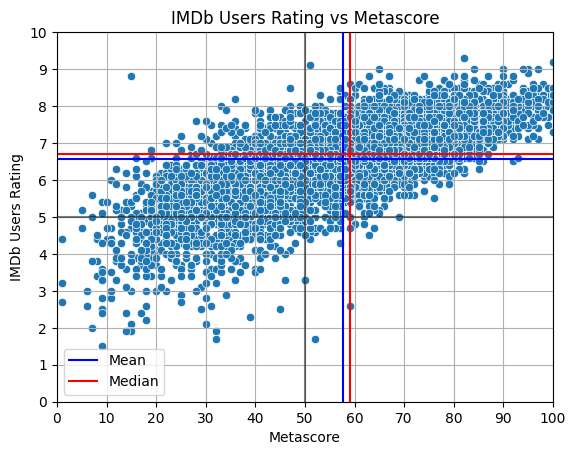

In [4]:
sns.scatterplot(x="metascore", y="imdb_rating", data=data)
plt.title("IMDb Users Rating vs Metascore")
plt.xticks(range(0, 101, 10))
plt.yticks(range(0, 11, 1))
plt.xlim(0, 100)
plt.ylim(0, 10)
plt.xlabel("Metascore")
plt.ylabel("IMDb Users Rating")
plt.grid()

# plot center lines
plt.axhline(y=5, color='k', linestyle='-', alpha=0.5)
plt.axvline(x=50, color='k', linestyle='-', alpha=0.5)

# plot mean lines
plt.axhline(y=data['imdb_rating'].mean(), color='b', linestyle='-')
plt.axvline(x=data['metascore'].mean(), color='b', linestyle='-')

# plot median lines
plt.axhline(y=data['imdb_rating'].median(), color='r', linestyle='-')
plt.axvline(x=data['metascore'].median(), color='r', linestyle='-')

# legend the lines but not the scatter plots
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
plt.legend(handles=[blue_line, red_line])

plt.show()

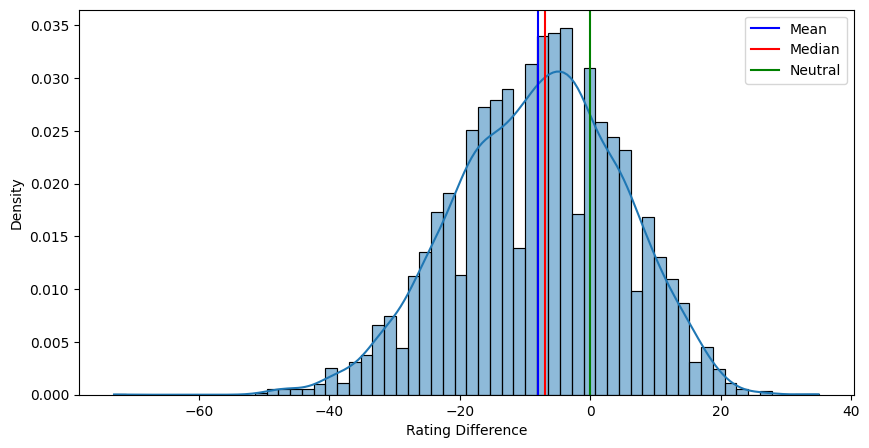

In [5]:
# Plot the mean and median and neutral rating difference
plt.figure(figsize=(10,5))
sns.histplot(data['rating_difference'], kde=True, stat='density', alpha=0.5)
plt.axvline(data['rating_difference'].mean(), color='b')
plt.axvline(data['rating_difference'].median(), color='r')
plt.axvline(0, color='g')
plt.xlabel('Rating Difference')
plt.ylabel('Density')

# Plot legend with corresponding colors
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
green_line = mlines.Line2D([], [], color='green', label='Neutral')
plt.legend(handles=[blue_line, red_line, green_line])

plt.show()

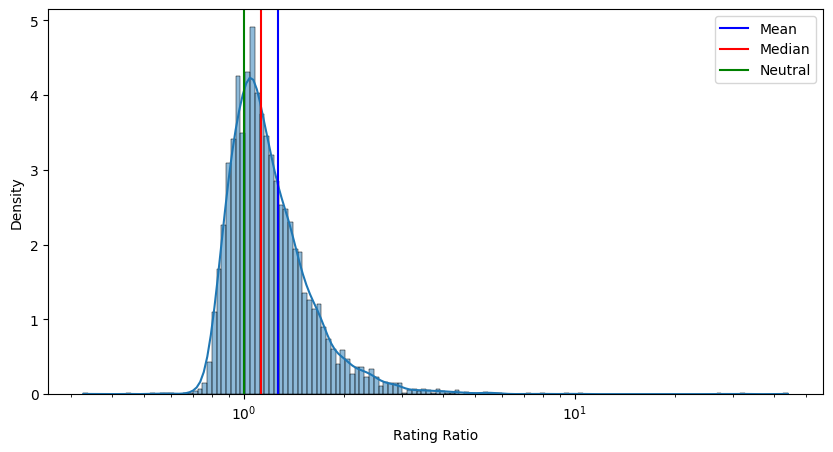

In [6]:
# Plot the mean and median and neutral rating ratio
plt.figure(figsize=(10,5))
sns.histplot(data['rating_ratio'], kde=True, stat='density', alpha=0.5, log_scale=True)
plt.axvline(data['rating_ratio'].mean(), color='b')
plt.axvline(data['rating_ratio'].median(), color='r')
plt.axvline(1, color='g')
plt.xlabel('Rating Ratio')
plt.ylabel('Density')

# Plot legend with corresponding colors
import matplotlib.lines as mlines
blue_line = mlines.Line2D([], [], color='blue', label='Mean')
red_line = mlines.Line2D([], [], color='red', label='Median')
green_line = mlines.Line2D([], [], color='green', label='Neutral')
plt.legend(handles=[blue_line, red_line, green_line])

plt.show()

# Exploration

## Genres

In [7]:
df_genres = process_genres(data)
print(f"Movies with genres value: {len(df_genres['freebase_id'].unique())}/{len(data['freebase_id'].unique())}")

Movies with genres value: 7770/7770


### Basic exploration

In [8]:
# Group by genre and calculate average rating_difference for each genre
genre_scores = df_genres.groupby('genres')['rating_difference'].mean().reset_index()

# Dropping rows where genre is NaN or Metascore is NaN
genre_scores = genre_scores.dropna()

# Sorting the genres by average rating_difference
genre_scores_sorted = genre_scores.sort_values(by='rating_difference', ascending=False)

# Display the top 10 genres
top_genres = genre_scores_sorted.head(10)
display(top_genres)

# Display the bottom 10 genres
flop_genres = genre_scores_sorted.tail(10)
display(flop_genres)

,genres,rating_difference
140,Foreign legion,18.000000
281,Star vehicle,16.000000
226,Point of view shot,16.000000
53,Cavalry Film,15.000000
47,British New Wave,15.000000
105,Ealing Comedies,15.000000
267,Silent film,14.545455
237,Propaganda film,9.333333
186,Kitchen sink realism,9.000000
40,Black-and-white,7.275862


,genres,rating_difference
293,Sword and sorcery,-18.538462
174,Indian Western,-18.666667
292,Sword and Sandal,-19.500000
176,Inspirational Drama,-19.733333
153,Gross-out film,-20.682927
152,Gross out,-20.682927
26,Archaeology,-21.000000
192,Live action,-25.500000
306,Werewolf fiction,-28.000000
217,Ninja movie,-29.000000


### Hotencoding

In [9]:
# Hot encode the genres
one_hot_movies_genres, one_hot_movies_genres_columns  = hotencode(df_genres, 'genres', id_column='freebase_id', prefix='onehot-genre')

# Add the rating_difference column
one_hot_movies_genres = one_hot_movies_genres.merge(data[['freebase_id', 'rating_difference']], on='freebase_id')

### Pearson Correlation

In [10]:
genres_pearsonr_results = perform_pearsonr(one_hot_movies_genres, one_hot_movies_genres_columns, 'rating_difference', print_results=True)

print(f"Significant results: {len(genres_pearsonr_results[genres_pearsonr_results['p_value'] < 0.05])}/{len(genres_pearsonr_results)}")

,correlation,p_value
onehot-genre_World cinema,0.172514,5.686407e-53
onehot-genre_Drama,0.169811,2.343363e-51
onehot-genre_Black-and-white,0.166375,2.420414e-49
onehot-genre_Art film,0.094680,6.102339e-17
onehot-genre_Documentary,0.077321,8.804232e-12
onehot-genre_Film noir,0.076741,1.257547e-11
onehot-genre_New Hollywood,0.073733,7.654204e-11
onehot-genre_Biography,0.070240,5.712804e-10
onehot-genre_Silent film,0.066990,3.405795e-09
onehot-genre_History,0.064335,1.379554e-08


,correlation,p_value
onehot-genre_Gross-out film,-0.072547,1.530600e-10
onehot-genre_Gross out,-0.072547,1.530600e-10
onehot-genre_Horror,-0.082430,3.407698e-13
onehot-genre_Slasher,-0.083825,1.353157e-13
onehot-genre_Teen,-0.088492,5.519274e-15
onehot-genre_Comedy,-0.088898,4.146261e-15
onehot-genre_Thriller,-0.089570,2.573478e-15
onehot-genre_Slapstick,-0.097525,6.945748e-18
onehot-genre_Action/Adventure,-0.114463,4.444883e-24
onehot-genre_Action,-0.141135,7.339506e-36


Significant results: 97/314


### OLS

In [11]:
genres_model_summary = perform_OLS(one_hot_movies_genres, one_hot_movies_genres_columns, 'rating_difference')
print(genres_model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     5.641
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          2.23e-174
Time:                        10:42:37   Log-Likelihood:                -29944.
No. Observations:                7770   AIC:                         6.052e+04
Df Residuals:                    7456   BIC:                         6.270e+04
Df Model:                         313                                         
Covariance Type:            nonrobust                                         
                                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [12]:
# Find the genres with p-values less than 0.05
significant_genres_df = list_significant_values(genres_model_summary, threshold=0.05, print_results=False)

significant_genres_df['genre'] = significant_genres_df['colname'].apply(lambda x: x.split('_')[1])

display(significant_genres_df.head(10))
display(significant_genres_df.tail(10))

,colname,coef,p_value,genre
47,onehot-genre_Point of view shot,26.7613,0.036,Point of view shot
21,onehot-genre_Ealing Comedies,26.2156,0.025,Ealing Comedies
10,onehot-genre_Cavalry Film,24.1035,0.040,Cavalry Film
30,onehot-genre_Gay Interest,18.7657,0.025,Gay Interest
31,onehot-genre_Giallo,18.2464,0.008,Giallo
43,onehot-genre_Mumblecore,14.4498,0.000,Mumblecore
24,onehot-genre_Experimental film,12.8642,0.004,Experimental film
16,onehot-genre_Coming-of-age film,12.5009,0.034,Coming-of-age film
7,onehot-genre_Black-and-white,11.7451,0.000,Black-and-white
54,onehot-genre_Silent film,10.4556,0.005,Silent film


,colname,coef,p_value,genre
11,onehot-genre_Childhood Drama,-6.8956,0.000,Childhood Drama
26,onehot-genre_Fantasy Drama,-7.9493,0.047,Fantasy Drama
8,onehot-genre_Bollywood,-9.7202,0.000,Bollywood
60,onehot-genre_Sword and sorcery,-9.7311,0.022,Sword and sorcery
5,onehot-genre_Avant-garde,-12.1595,0.013,Avant-garde
39,onehot-genre_Inspirational Drama,-12.7453,0.000,Inspirational Drama
0,onehot-genre_Acid western,-17.5629,0.013,Acid western
40,onehot-genre_Live action,-18.9189,0.024,Live action
29,onehot-genre_Gay,-19.5572,0.020,Gay
37,onehot-genre_Indian Western,-28.4458,0.000,Indian Western


In [13]:
significant_genres_columns = significant_genres_df['colname'].tolist()

### SVR

In [14]:
genres_svr_results = perform_SVR(one_hot_movies_genres, one_hot_movies_genres_columns, 'rating_difference', kfolds=5, print_results=True)

Cross-validating: 100%|██████████| 5/5 [00:49<00:00,  9.92s/fold]


,mean,std
r2,0.107581,0.011934
mse,143.700986,8.317434
mae,9.607291,0.233480


## Actors

### Preprocessing

In [15]:
data_characters = pd.read_csv('data/preprocessed/character.metadata.preprocessed.tsv', sep='\t')

# Filter out movies that are not in the movies dataset
data_characters = data_characters[data_characters['wikipedia_id'].isin(data['wikipedia_id'])]

print(f'Actors: {len(data_characters["freebase_actor_id"].unique())}')

Actors: 22416


In [16]:
movies_threshold = 6
df_actors = process_actors(data_characters, movies_threshold=movies_threshold)

print(f"Actors with >={movies_threshold} movies: {len(df_actors['freebase_actor_id'].unique())}/{len(data_characters['freebase_actor_id'].unique())}")
print(f"Movies with actors with >={movies_threshold} movies: {len(df_actors['wikipedia_id'].unique())}/{len(data)}")

Actors with >=6 movies: 3151/22416
Movies with actors with >=6 movies: 6156/7770


### Hotencoding

In [17]:
# Hot encode the actor freebase id column 
one_hot_actors, one_hot_actors_columns = hotencode(df_actors, 'freebase_actor_id', id_column='wikipedia_id', prefix='onehot-actor')

# Add the rating_difference column to the one hot encoded dataframe
one_hot_actors = one_hot_actors.merge(data[['wikipedia_id', 'rating_difference']], on='wikipedia_id')

### Pearson Correlation

In [18]:
actors_pearsonr_results = perform_pearsonr(one_hot_actors, one_hot_actors_columns, 'rating_difference', print_results=True)

print(f"Significant results: {len(actors_pearsonr_results[actors_pearsonr_results['p_value'] < 0.05])}/{len(actors_pearsonr_results)}")

,correlation,p_value
onehot-actor_/m/02hfsd,0.062650,8.682663e-07
onehot-actor_/m/04sry,0.061693,1.272015e-06
onehot-actor_/m/0cbkc,0.061683,1.277098e-06
onehot-actor_/m/021t8p,0.056423,9.441287e-06
onehot-actor_/m/09qh1,0.055850,1.162556e-05
onehot-actor_/m/016yvw,0.055024,1.563473e-05
onehot-actor_/m/0668qk,0.054638,1.792995e-05
onehot-actor_/m/0p8r1,0.053008,3.167281e-05
onehot-actor_/m/014zcr,0.052987,3.190623e-05
onehot-actor_/m/043gj,0.052856,3.337227e-05


,correlation,p_value
onehot-actor_/m/0b10t7,-0.047611,0.000186
onehot-actor_/m/04bk4c,-0.048098,0.000160
onehot-actor_/m/0670jl,-0.048175,0.000156
onehot-actor_/m/01dkpb,-0.049798,0.000093
onehot-actor_/m/03hv_6,-0.053159,0.000030
onehot-actor_/m/01fyzy,-0.054207,0.000021
onehot-actor_/m/038rzr,-0.054293,0.000020
onehot-actor_/m/0pz91,-0.056467,0.000009
onehot-actor_/m/06rq2l,-0.056486,0.000009
onehot-actor_/m/01p4vl,-0.060183,0.000002


Significant results: 428/3151


### OLS

In [19]:
# Fit a OLS model
actors_model_summary = perform_OLS(one_hot_actors, one_hot_actors_columns, 'rating_difference')
print(actors_model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.598
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     1.425
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           7.22e-23
Time:                        10:44:19   Log-Likelihood:                -21517.
No. Observations:                6156   AIC:                         4.933e+04
Df Residuals:                    3008   BIC:                         7.050e+04
Df Model:                        3147                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [20]:
# Print the highest and lowest coefficients sorted
significant_actors_df = list_significant_values(actors_model_summary, threshold=0.05, print_results=False)

# Add actor name to the DataFrame
significant_actors_df['freebase_actor_id'] = significant_actors_df['colname'].apply(lambda x: x.split('_')[1])
significant_actors_df = pd.merge(significant_actors_df, df_actors[['freebase_actor_id', 'actor_name']].drop_duplicates(), left_on='freebase_actor_id', right_on='freebase_actor_id', how='left')

display(significant_actors_df.head(15))
display(significant_actors_df.tail(15))

,colname,coef,p_value,freebase_actor_id,actor_name
0,onehot-actor_/m/02rq18t,24.8000,0.001,/m/02rq18t,Brooke Smith
1,onehot-actor_/m/0bhbzd3,22.0536,0.022,/m/0bhbzd3,Robert Capron
2,onehot-actor_/m/082bkm,20.5436,0.001,/m/082bkm,Wes Studi
3,onehot-actor_/m/083wr9,20.3769,0.039,/m/083wr9,Jess Harnell
4,onehot-actor_/m/0fn5bx,20.0536,0.006,/m/0fn5bx,Jayma Mays
5,onehot-actor_/m/06b4wb,19.7775,0.013,/m/06b4wb,Russi Taylor
6,onehot-actor_/m/06hhrs,19.5302,0.001,/m/06hhrs,Richard Kind
7,onehot-actor_/m/04m7fz,18.6315,0.031,/m/04m7fz,Kirk Acevedo
8,onehot-actor_/m/03y_46,18.3527,0.018,/m/03y,NaN
9,onehot-actor_/m/050zk6,17.8900,0.006,/m/050zk6,Catalina Sandino Moreno


,colname,coef,p_value,freebase_actor_id,actor_name
179,onehot-actor_/m/0c5krz,-17.2306,0.030,/m/0c5krz,Ever Carradine
180,onehot-actor_/m/06qw6j,-17.2428,0.005,/m/06qw6j,Ivana Miličević
181,onehot-actor_/m/049qx,-17.5580,0.018,/m/049qx,Kylie Minogue
182,onehot-actor_/m/02z3zp,-17.9193,0.030,/m/02z3zp,Garry Shandling
183,onehot-actor_/m/01rw116,-18.2085,0.004,/m/01rw116,Scatman Crothers
184,onehot-actor_/m/01x0kg7,-18.4284,0.001,/m/01x0kg7,Norm Macdonald
185,onehot-actor_/m/07f469,-18.4614,0.001,/m/07f469,Kevin Gage
186,onehot-actor_/m/0q9vf,-18.6579,0.039,/m/0q9vf,Michael Richards
187,onehot-actor_/m/07vnp4,-18.9311,0.001,/m/07vnp4,Bill Moseley
188,onehot-actor_/m/07fpm3,-19.3223,0.001,/m/07fpm3,Iain Glen


In [21]:
significant_actors_columns = significant_actors_df['colname'].tolist()

In [22]:
list_movies_of_actor(df_actors, data, '/m/0337zp')

array(['Kristy Swanson'], dtype=object)

,wikipedia_id,freebase_id,name,revenue,runtime,languages,countries,genres,release_date_datetime,imdb_id,metacritic_id,imdb_rating,imdb_votes,metascore,count_nomination,count_award,imdb_rating_scaled,rating_difference,rating_ratio
2547,4231,/m/01cbx,Buffy the Vampire Slayer,16624456.0,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02kdv5l"": ""Action"", ""/m/03npn"": ""Horror"",...",1992-07-31,tt0103893,movie/buffy-the-vampire-slayer,5.7,48463.0,48.0,0,0,57.0,-9.0,1.187500
3985,1048388,/m/041ggx,Hot Shots!,181096164.0,83.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0gf28"": ""Parody"", ""/m/01hwc6"": ""Absurdism...",1991-07-31,tt0102059,movie/hot-shots!,6.7,114406.0,61.0,0,0,67.0,-6.0,1.098361
5002,88326,/m/0m491,Ferris Bueller's Day Off,70136369.0,103.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01q03"": ""Cult"", ""/m/07s9rl0"": ""Drama"", ""/...",1986-06-11,tt0091042,movie/ferris-buellers-day-off,7.8,378640.0,61.0,1,2,78.0,-17.0,1.278689
5327,454223,/m/02bg6w,Pretty in Pink,40471663.0,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/01t_vv"": ""...",1986-02-28,tt0091790,movie/pretty-in-pink,6.7,86832.0,56.0,0,0,67.0,-11.0,1.196429
5624,695435,/m/033gkt,Higher Learning,38000000.0,128.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hn10"": ""LGBT"", ""/m/0hj3n0w"": ""Ensemble F...",1995-01-11,tt0113305,movie/higher-learning,6.5,21188.0,54.0,1,1,65.0,-11.0,1.203704
5778,1389153,/m/04ynq7,"Dude, Where's My Car?",73180723.0,64.0,"{""/m/064_8sq"": ""French Language"", ""/m/03_9r"": ...","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/0556j8"": ""...",2000-12-10,tt0242423,movie/dude-wheres-my-car,5.5,144209.0,30.0,6,1,55.0,-25.0,1.833333
6554,3787708,/m/0b0102,8 Heads in a Duffel Bag,3602884.0,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0hj3m_x"": ""Crime Comedy"", ""/m/0gw5w78"": ""...",1997-04-18,tt0118541,movie/8-heads-in-a-duffel-bag,5.4,10937.0,15.0,0,0,54.0,-39.0,3.600000
7052,501340,/m/02hxhz,Big Daddy,234801895.0,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hqxf"": ""Family Film"", ""/m/02h8pkk"": ""Fam...",1999-06-25,tt0142342,movie/big-daddy,6.4,229521.0,41.0,14,8,64.0,-23.0,1.560976


### SVR

In [23]:
actors_svr_results = perform_SVR(one_hot_actors, one_hot_actors_columns, 'rating_difference', kfolds=5, print_results=True)

Cross-validating: 100%|██████████| 5/5 [05:13<00:00, 62.78s/fold]


,mean,std
r2,0.040330,0.010862
mse,151.995643,6.188160
mae,9.991288,0.253825


## Runtime

In [24]:
df_runtime = data.copy()
df_runtime.dropna(subset=['runtime'], inplace=True)
print(f"Movies with runtime value: {len(df_runtime)}/{len(data)}")

Movies with runtime value: 7493/7770


### Visual exploration

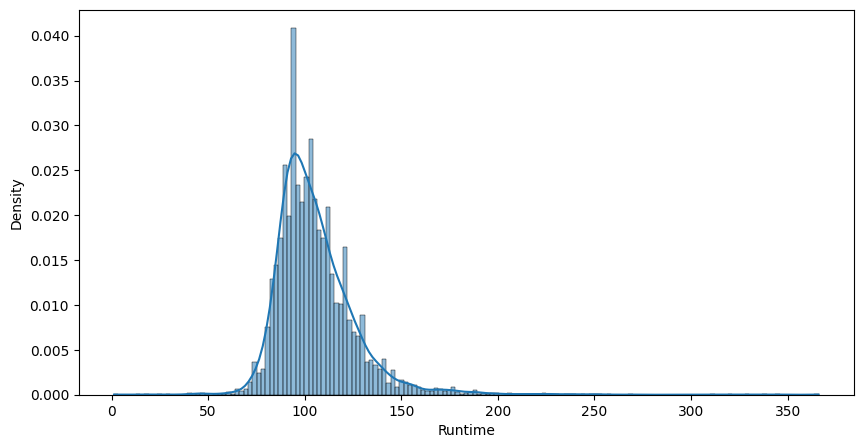

In [25]:
# Plot distribution of runtime
plt.figure(figsize=(10,5))
sns.histplot(df_runtime['runtime'], kde=True, stat='density', alpha=0.5)
plt.xlabel('Runtime')
plt.ylabel('Density')
plt.show()

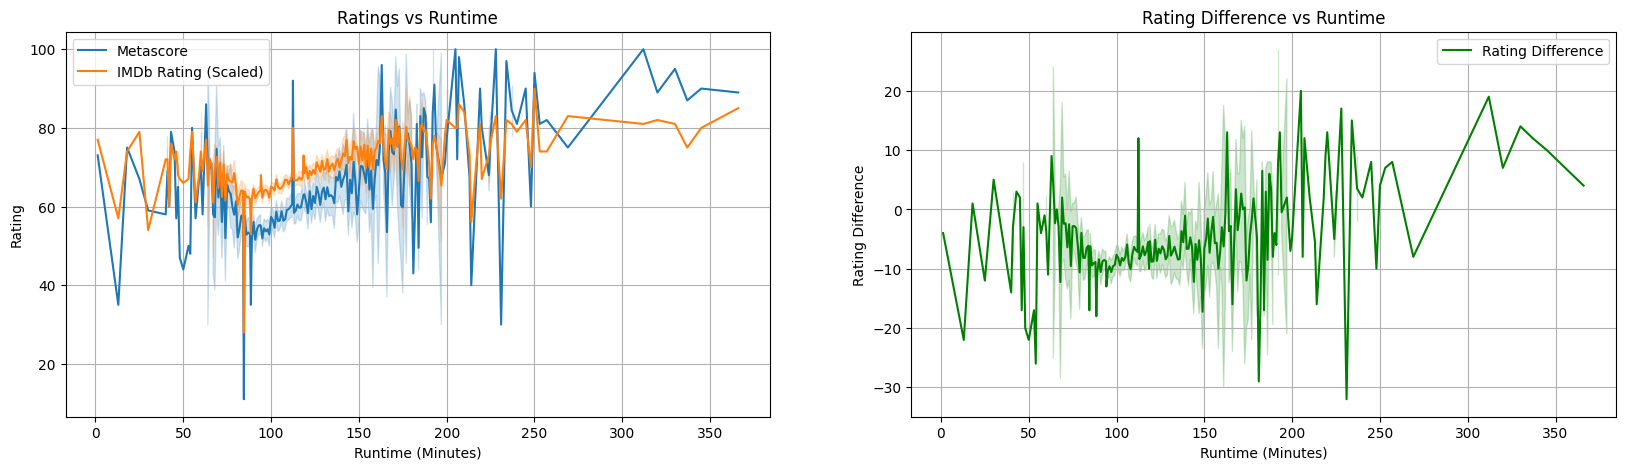

In [26]:
# Plot the distribution of rating difference per runtime
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="runtime", y="metascore", data=df_runtime, label='Metascore', ax=ax[0])
sns.lineplot(x="runtime", y="imdb_rating_scaled", data=df_runtime, label='IMDb Rating (Scaled)', ax=ax[0])

sns.lineplot(x="runtime", y="rating_difference", data=df_runtime, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Runtime")
ax[0].set_xlabel("Runtime (Minutes)")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Runtime")
ax[1].set_xlabel("Runtime (Minutes)")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

The plot shows a noisy relationship between rating difference and runtime, with no clear pattern. The data points are widely spread out, indicating a lot of variability in the rating differences for movies of similar lengths.

### Pearson correlation

In [27]:
runtime_pearsonr_results = perform_pearsonr(df_runtime, ['runtime'], 'rating_difference', print_results=True)

,correlation,p_value
runtime,0.077735,1.605720e-11


### OLS

In [28]:
# Fit OLS
runtime_model_summary = perform_OLS(df_runtime, 'runtime', 'rating_difference')
print(runtime_model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     45.54
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           1.61e-11
Time:                        10:49:37   Log-Likelihood:                -29623.
No. Observations:                7493   AIC:                         5.925e+04
Df Residuals:                    7491   BIC:                         5.926e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.7768      0.740    -17.271      0.0

- The R-squared value is 0.006, which means that only 0.6% of the variance in the rating difference is explained by the runtime. This indicates a very weak linear relationship between runtime and rating difference.
  
- The constant (intercept) coefficient is -12.7768 with a p-value close to 0, suggesting that the intercept is significantly different from 0. However, given that runtime cannot be 0, the practical interpretation of the intercept is limited.
  
- The runtime coefficient is 0.0463, indicating that for every additional minute of runtime, the rating difference increases by 0.0463 on average. While this is statistically significant (p-value < 0.001), the effect size is very small.

## Release date

### Preprocessing

In [29]:
df_release_date = data.copy()
df_release_date['release_date_datetime'] = pd.to_datetime(df_release_date['release_date_datetime'])
df_release_date['year'] = df_release_date['release_date_datetime'].dt.year
df_release_date['month'] = df_release_date['release_date_datetime'].dt.month

df_release_date = df_release_date.dropna(subset=['year', 'month'])
print(f'Movies with a release date and month: {len(df_release_date)}/{len(data)}')

Movies with a release date and month: 7702/7770


### Visual exploration

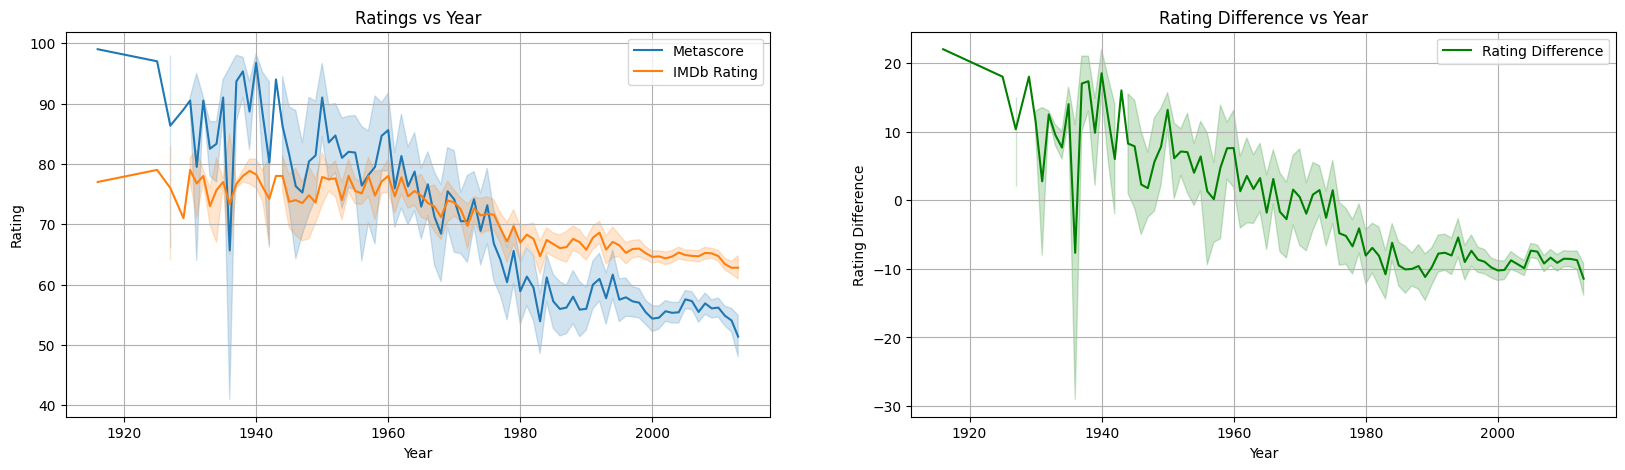

In [30]:
# Plot the distribution of rating difference per year
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="year", y="metascore", data=df_release_date, label='Metascore', ax=ax[0])
sns.lineplot(x="year", y="imdb_rating_scaled", data=df_release_date, label='IMDb Rating', ax=ax[0])

sns.lineplot(x="year", y="rating_difference", data=df_release_date, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Year")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Year")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

- The first set of plots shows that both the Metascore and IMDb rating have a general downward trend over the years. This could suggest that either movies are getting worse, or perhaps more likely, that scoring criteria have become stricter over time.

- The plot for rating differences over the years indicates that the gap between Metascore and IMDb ratings has generally been widening. Early in the data, Metascore ratings are higher than IMDb, and over time, this trend reverses.

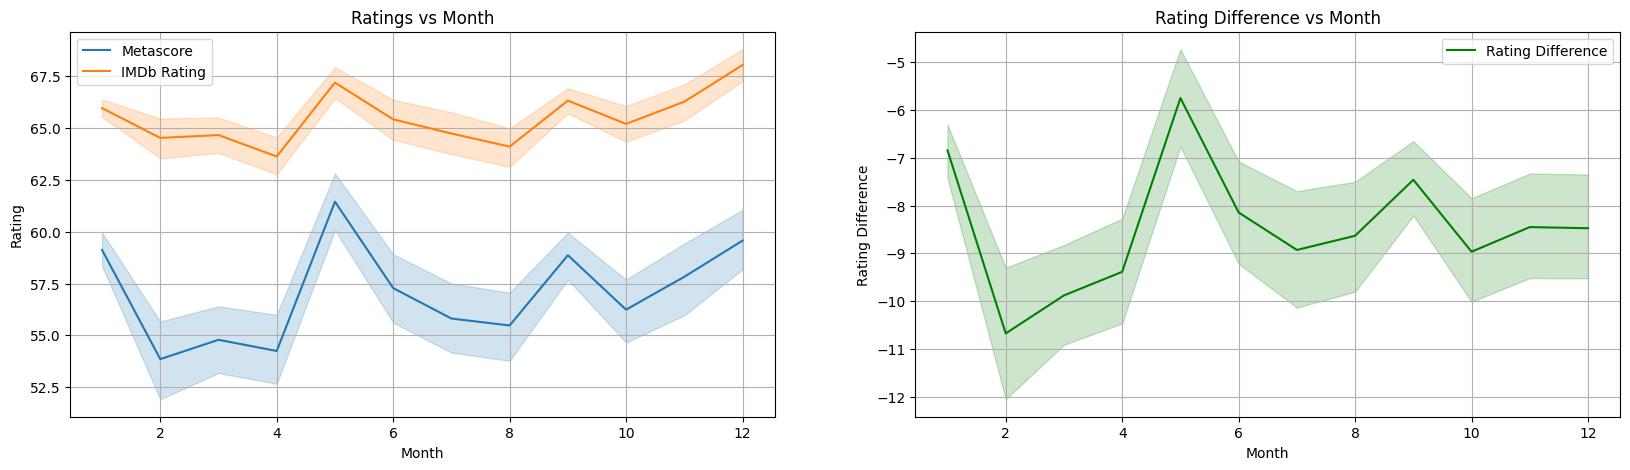

In [31]:
# Plot the distribution of rating difference per month
fig, ax = plt.subplots(1, 2 ,figsize=(20,5))
sns.lineplot(x="month", y="metascore", data=df_release_date, label='Metascore', ax=ax[0])
sns.lineplot(x="month", y="imdb_rating_scaled", data=df_release_date, label='IMDb Rating', ax=ax[0])

sns.lineplot(x="month", y="rating_difference", data=df_release_date, label='Rating Difference', ax=ax[1], color='g')
ax[0].set_title("Ratings vs Month")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Rating")
ax[0].grid()

ax[1].set_title("Rating Difference vs Month")
ax[1].set_xlabel("Month")
ax[1].set_ylabel("Rating Difference")
ax[1].grid()
plt.show()

- The monthly plots indicate some seasonality in ratings, with certain months having higher or lower average ratings. This could be due to the type of movies typically released in those months (e.g., Oscar-bait films in December).

- The monthly rating difference plot shows that the discrepancy between the two rating sources also varies by month, with some months showing a larger gap than others.

### Pearson correlation

In [32]:
release_date_pearsor_results = perform_pearsonr(df_release_date, ['year', 'month'], 'rating_difference', print_results=True)

,correlation,p_value
month,-0.024008,3.512578e-02
year,-0.201596,1.906067e-71


### OLS

In [33]:
# Fit a linear regression model
release_date_model_summary = perform_OLS(df_release_date, ['year', 'month'], 'rating_difference')
print(release_date_model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     166.5
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           1.65e-71
Time:                        10:49:39   Log-Likelihood:                -30330.
No. Observations:                7702   AIC:                         6.067e+04
Df Residuals:                    7699   BIC:                         6.069e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        377.4519     21.250     17.762      0.0

- The model suggests that both year and month are significant predictors of the rating difference.

- The coefficient for year is -0.1925, indicating that with each passing year, the rating difference decreases by 0.1925 points. Given the R-squared value of 0.041, we know that year and month together explain about 4.1% of the variance in rating difference, which is not a lot, but it is significant.

- The coefficient for month is -0.0953, suggesting a smaller but still significant monthly effect on rating differences.

## Countries

In [34]:
df_countries = process_countries(data)

print(f"Movies with countries: {len(df_countries['freebase_id'].unique())}/{len(data)}")

Movies with countries: 7770/7770


### Hotencoding

In [35]:
# Hot encode countries per movie
one_hot_countries, one_hot_countries_columns = hotencode(df_countries, 'countries', id_column='wikipedia_id', prefix='onehot-country')

# Add the rating_difference column
one_hot_countries = one_hot_countries.merge(df_countries[['wikipedia_id', 'rating_difference']], on='wikipedia_id')

### Pearson Correlation

In [36]:
countries_pearsonr_results = perform_pearsonr(one_hot_countries, one_hot_countries_columns, 'rating_difference', print_results=True)

print(f"Significant results: {len(countries_pearsonr_results[countries_pearsonr_results['p_value'] < 0.05])}/{len(countries_pearsonr_results)}")

,correlation,p_value
onehot-country_France,0.146047,3.544308e-56
onehot-country_Switzerland,0.077438,7.381274e-17
onehot-country_Iran,0.070655,2.776519e-14
onehot-country_Italy,0.068905,1.177047e-13
onehot-country_Belgium,0.058851,2.376021e-10
onehot-country_Taiwan,0.048799,1.509726e-07
onehot-country_England,0.048122,2.238230e-07
onehot-country_Russia,0.046649,5.174606e-07
onehot-country_Poland,0.045678,8.874738e-07
onehot-country_Cameroon,0.043761,2.494141e-06


,correlation,p_value
onehot-country_Bulgaria,-0.018076,5.187042e-02
onehot-country_Slovakia,-0.020384,2.834699e-02
onehot-country_India,-0.022226,1.681990e-02
onehot-country_Romania,-0.022721,1.452824e-02
onehot-country_Germany,-0.023125,1.286810e-02
onehot-country_Socialist Federal Republic of Yugoslavia,-0.023297,1.221349e-02
onehot-country_Cambodia,-0.026057,5.065568e-03
onehot-country_Qatar,-0.038702,3.129003e-05
onehot-country_Canada,-0.055611,2.157920e-09
onehot-country_United States of America,-0.244280,8.721133e-157


Significant results: 49/115


### OLS

In [37]:
countries_model_summary = perform_OLS(one_hot_countries, one_hot_countries_columns, 'rating_difference')
print(countries_model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     12.19
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          6.52e-204
Time:                        10:49:40   Log-Likelihood:                -45074.
No. Observations:               11569   AIC:                         9.038e+04
Df Residuals:                   11454   BIC:                         9.122e+04
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

- The Adjusted R-squared value is 0.099, meaning that roughly 9.9% of the variance in the rating difference can be explained by the model. This is a significant improvement from previous models you mentioned, but still suggests that there are other factors not included in the model that influence the rating difference.

In [38]:
# Print the highest and lowest coefficients sorted
significant_countries_df = list_significant_values(countries_model_summary, threshold=0.05, print_results=False)

significant_countries_df['country'] = significant_countries_df['colname'].apply(lambda x: x.split('_')[1])

display(significant_countries_df.head(15))
display(significant_countries_df.tail(15))

,colname,coef,p_value,country
35,onehot-country_Serbia and Montenegro,29.5768,0.000,Serbia and Montenegro
0,onehot-country_Albania,21.0608,0.001,Albania
44,onehot-country_Weimar Republic,19.7990,0.001,Weimar Republic
4,onehot-country_Bahamas,15.1371,0.006,Bahamas
28,onehot-country_Panama,13.0024,0.031,Panama
22,onehot-country_Lithuania,12.5008,0.006,Lithuania
36,onehot-country_Slovak Republic,11.9341,0.013,Slovak Republic
6,onehot-country_Cameroon,11.3928,0.031,Cameroon
21,onehot-country_Kuwait,10.7567,0.048,Kuwait
37,onehot-country_Soviet Union,10.2146,0.009,Soviet Union


,colname,coef,p_value,country
9,onehot-country_Czech Republic,-3.7378,0.002,Czech Republic
16,onehot-country_India,-3.8242,0.000,India
20,onehot-country_Kingdom of Great Britain,-5.4617,0.041,Kingdom of Great Britain
43,onehot-country_United States of America,-5.7336,0.000,United States of America
33,onehot-country_Romania,-6.0635,0.000,Romania
10,onehot-country_Denmark,-6.8253,0.000,Denmark
15,onehot-country_Greece,-6.9929,0.007,Greece
45,onehot-country_Yugoslavia,-8.2679,0.025,Yugoslavia
42,onehot-country_Tunisia,-10.9316,0.001,Tunisia
18,onehot-country_Isle of Man,-11.4580,0.007,Isle of Man


- The countries with positive coefficients (like Albania, Bahamas) suggest that movies associated with these countries tend to have a higher Metascore compared to IMDb rating.

- Conversely, countries with negative coefficients (like Denmark, Bulgaria) suggest that movies associated with these countries tend to have a lower Metascore compared to IMDb rating.

- The p_value indicates the statistical significance of these coefficients. For example, countries like Serbia and Montenegro, Albania, and the Weimar Republic have coefficients that are statistically significant (p < 0.05), meaning we can be confident that these are not due to random chance.

It's important to note that correlation does not imply causation. The coefficients must also be interpreted with caution, especially for countries with a small number of movies represented in the dataset, as the estimates may be less reliable.

In [39]:
significant_countries_columns = significant_countries_df['colname'].tolist()

### SVR

In [40]:
countries_svr_results = perform_SVR(one_hot_countries, one_hot_countries_columns, 'rating_difference', kfolds=5, print_results=True)

Cross-validating:   0%|          | 0/5 [00:00<?, ?fold/s]

Cross-validating: 100%|██████████| 5/5 [00:47<00:00,  9.58s/fold]


,mean,std
r2,0.100208,0.010911
mse,143.070138,5.894445
mae,9.466715,0.188291


## Tropes

### Preprocessing

In [4]:
data_tropes = pd.read_csv('data/processed/tropes.csv')

In [5]:
df_tropes = data_tropes.copy()
print(f"Movies with tropes: {len(df_tropes['imdb_id'].unique())}/{len(data['imdb_id'].unique())}")

Movies with tropes: 2741/7770


In [26]:
# Keep tropes with at least n movies
n = 20
df_tropes = df_tropes.groupby('trope_id').filter(lambda x: len(x) >= n)
print(f"Unique tropes after filtering: {len(df_tropes['trope_id'].unique())}/{len(data_tropes['trope_id'].unique())}")

Unique tropes after filtering: 2878/23790


### Hotencoding

In [13]:
# Hot encode the cluster_name per freebase_id
one_hot_tropes, one_hot_tropes_columns = hotencode(df_tropes, 'trope_id', id_column='imdb_id', prefix='onehot-tropes')

# Add rating_difference column
one_hot_tropes = one_hot_tropes.merge(data[['rating_difference', 'imdb_id']], on='imdb_id')

### Pearson Correlation

In [14]:
tropes_pearsonr_results = perform_pearsonr(one_hot_tropes, one_hot_tropes_columns, 'rating_difference', print_results=True)

print(f"Significant results: {len(tropes_pearsonr_results[tropes_pearsonr_results['p_value'] < 0.05])}/{len(tropes_pearsonr_results)}")

,correlation,p_value
onehot-tropes_t11242,0.092899,0.000003
onehot-tropes_t05943,0.092859,0.000003
onehot-tropes_t04112,0.085316,0.000020
onehot-tropes_t05360,0.080540,0.000056
onehot-tropes_t03485,0.079024,0.000078
onehot-tropes_t16383,0.077693,0.000102
onehot-tropes_t26668,0.076595,0.000128
onehot-tropes_t04299,0.073531,0.000237
onehot-tropes_t21739,0.072506,0.000289
onehot-tropes_t16656,0.071752,0.000335


,correlation,p_value
onehot-tropes_t30950,-0.073488,2.389423e-04
onehot-tropes_t27271,-0.074065,2.132460e-04
onehot-tropes_t20514,-0.074896,1.808036e-04
onehot-tropes_t13503,-0.079990,6.336870e-05
onehot-tropes_t29457,-0.085417,1.935186e-05
onehot-tropes_t08010,-0.086105,1.656271e-05
onehot-tropes_t29237,-0.086656,1.461245e-05
onehot-tropes_t09561,-0.090284,6.282872e-06
onehot-tropes_t15980,-0.099167,6.935852e-07
onehot-tropes_t14656,-0.105768,1.188042e-07


Significant results: 315/2878


### OLS

In [15]:
# Fit OLS
tropes_model_summary = perform_OLS(one_hot_tropes, one_hot_tropes_columns, 'rating_difference')
print(tropes_model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     1.190
Date:                Mon, 11 Dec 2023   Prob (F-statistic):              0.184
Time:                        11:22:29   Log-Likelihood:                -5147.2
No. Observations:                2495   AIC:                         1.515e+04
Df Residuals:                      66   BIC:                         2.929e+04
Df Model:                        2428                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -5.0298 

In [19]:
# Print the highest and lowest coefficients sorted
significant_tropes_df = list_significant_values(tropes_model_summary, threshold=0.05, print_results=False)

significant_tropes_df['trope_id'] = significant_tropes_df['colname'].apply(lambda x: "_".join(x.split('_')[1:]))

display(significant_tropes_df)

,colname,coef,p_value,trope_id
145,onehot-tropes_t29067,99.5577,0.002,t29067
110,onehot-tropes_t22392,96.4385,0.004,t22392
47,onehot-tropes_t09821,90.6826,0.001,t09821
146,onehot-tropes_t29216,86.3733,0.020,t29216
144,onehot-tropes_t28991,84.1682,0.047,t28991
...,...,...,...,...
138,onehot-tropes_t27603,-76.7139,0.032,t27603
21,onehot-tropes_t04207,-78.0205,0.008,t04207
141,onehot-tropes_t28051,-83.4381,0.001,t28051
134,onehot-tropes_t26782,-89.0214,0.002,t26782


In [18]:
significant_tropes_columns = significant_tropes_df['colname'].tolist()

In [21]:
significant_tropes_df['trope_name'] = significant_tropes_df['trope_id'].apply(lambda x: df_tropes[df_tropes['trope_id'] == x]['trope'].iloc[0])

In [24]:
display(significant_tropes_df.head(20))
display(significant_tropes_df.tail(20))

,colname,coef,p_value,trope_id,trope_name
145,onehot-tropes_t29067,99.5577,0.002,t29067,GenreBuster
110,onehot-tropes_t22392,96.4385,0.004,t22392,TechnologyPorn
47,onehot-tropes_t09821,90.6826,0.001,t09821,HarmlessFreezing
146,onehot-tropes_t29216,86.3733,0.020,t29216,SexEqualsDeath
144,onehot-tropes_t28991,84.1682,0.047,t28991,ScaryBlackMen
2,onehot-tropes_t00323,83.0533,0.021,t00323,AdoredByTheNetwork
82,onehot-tropes_t15533,80.0606,0.002,t15533,NoOSHACompliance
115,onehot-tropes_t23063,76.8126,0.005,t23063,TheLancer
122,onehot-tropes_t24518,74.6489,0.008,t24518,TryAndFollow
113,onehot-tropes_t22847,72.6521,0.008,t22847,TheEndOrIsIt


,colname,coef,p_value,trope_id,trope_name
79,onehot-tropes_t14492,-61.0895,0.009,t14492,MonumentalBattle
143,onehot-tropes_t28784,-62.7646,0.032,t28784,Tritagonist
28,onehot-tropes_t05121,-63.0821,0.012,t05121,DarkIsNotEvil
43,onehot-tropes_t08964,-64.5696,0.017,t08964,GenreBusting
97,onehot-tropes_t18761,-64.6063,0.001,t18761,RevealingCoverup
128,onehot-tropes_t26011,-65.3207,0.015,t26011,WhyDontYouJustShootHim
71,onehot-tropes_t13084,-65.8924,0.006,t13084,LockAndLoadMontage
67,onehot-tropes_t12666,-66.1807,0.010,t12666,LawyerFriendlyCameo
103,onehot-tropes_t19873,-66.4712,0.029,t19873,SerendipityWritesThePlot
101,onehot-tropes_t19544,-67.0576,0.024,t19544,ScreamingWarrior


# Conclusion

### Preprocessing

In [48]:
# Genres
one_hot_movies_genres, one_hot_movies_genres_columns  = hotencode(df_genres, 'genres', id_column='freebase_id', prefix='onehot-genre')
one_hot_movies_genres = one_hot_movies_genres.merge(data[['freebase_id']], on='freebase_id')

# Actors
one_hot_actors, one_hot_actors_columns = hotencode(df_actors, 'freebase_actor_id', id_column='wikipedia_id', prefix='onehot-actor')
one_hot_actors = one_hot_actors.merge(data[['freebase_id', 'wikipedia_id']], on='wikipedia_id')

# Countries
one_hot_countries, one_hot_countries_columns = hotencode(df_countries, 'countries', id_column='wikipedia_id', prefix='onehot-country')
one_hot_countries = one_hot_countries.merge(data[['wikipedia_id']], on='wikipedia_id')

# Tropes
one_hot_tropes, one_hot_tropes_columns = hotencode(df_tropes, 'cluster_name', id_column='freebase_id', prefix='onehot-tvtropes')
one_hot_tropes = one_hot_tropes.merge(data[['freebase_id']], on='freebase_id')

In [49]:
# Merge in a global df
one_hot_global = one_hot_movies_genres.merge(one_hot_actors, on='freebase_id', how='right')
#one_hot_global = one_hot_global.merge(one_hot_tropes, on='imdb_id', how='right')
one_hot_global = one_hot_global.merge(one_hot_countries, on='wikipedia_id')

global_columns = one_hot_movies_genres_columns + one_hot_actors_columns + one_hot_countries_columns
#significant_columns = significant_genres_columns + significant_actors_columns + significant_countries_columns

In [50]:
# Add the rating_difference column
one_hot_global_merged = one_hot_global.merge(data[['freebase_id', 'rating_difference']], on='freebase_id')

### OLS

In [51]:
# Fit ols
global_model_summary = perform_OLS(one_hot_global_merged, global_columns, 'rating_difference')
print(global_model_summary)

                            OLS Regression Results                            
Dep. Variable:      rating_difference   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     1.584
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           1.05e-35
Time:                        10:51:43   Log-Likelihood:                -20813.
No. Observations:                6156   AIC:                         4.869e+04
Df Residuals:                    2624   BIC:                         7.244e+04
Df Model:                        3531                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [52]:
# Print significant columns
significant_global_df = list_significant_values(global_model_summary, threshold=0.05, print_results=True)

,colname,coef,p_value
216,onehot-country_Slovenia,46.6526,0.024
13,onehot-genre_Gay Interest,40.1465,0.016
214,onehot-country_Malta,36.9838,0.012
196,onehot-actor_/m/0fn5bx,23.0284,0.001
139,onehot-actor_/m/06b4wb,22.8957,0.004
81,onehot-actor_/m/02rq18t,21.5774,0.004
136,onehot-actor_/m/062w4b,21.1365,0.007
178,onehot-actor_/m/0bhbzd3,20.4625,0.036
188,onehot-actor_/m/0cfr_9,19.6614,0.017
157,onehot-actor_/m/07wlyr,18.8623,0.014


,colname,coef,p_value
84,onehot-actor_/m/02z3zp,-19.5641,0.019
110,onehot-actor_/m/040nqh,-19.6297,0.013
55,onehot-actor_/m/01vvyc_,-20.3188,0.008
87,onehot-actor_/m/0337zp,-21.0409,0.004
142,onehot-actor_/m/06qw6j,-21.2675,0.001
19,onehot-genre_Live action,-22.0738,0.033
18,onehot-genre_Indian Western,-29.1381,0.003
4,onehot-genre_Beach Film,-37.4069,0.036
12,onehot-genre_Gay,-39.9171,0.013
211,onehot-country_Bosnia and Herzegovina,-59.8871,0.017


In [53]:
list_movies_of_actor(df_actors, data, '/m/06qw6j', limit=None)

array(['Ivana Miličević'], dtype=object)

,wikipedia_id,freebase_id,name,revenue,runtime,languages,countries,genres,release_date_datetime,imdb_id,metacritic_id,imdb_rating,imdb_votes,metascore,count_nomination,count_award,imdb_rating_scaled,rating_difference,rating_ratio
561,3606413,/m/09pjp3,Impostor,8145549.0,102.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0hj3mt0"": ""Alien...",2001-12-04,tt0160399,movie/impostor,6.1,24366.0,33.0,0,0,61.0,-28.0,1.848485
786,3635829,/m/09rcwd,Running Scared,9380029.0,121.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0gw5w78"": ""Gangs...",2006-01-06,tt0404390,movie/running-scared,7.3,102668.0,41.0,4,0,73.0,-32.0,1.780488
2177,370064,/m/020bv3,Love Actually,246942017.0,136.0,"{""/m/064_8sq"": ""French Language"", ""/m/02bjrlw""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...",2003-09-07,tt0314331,movie/love-actually,7.6,508749.0,55.0,29,10,76.0,-21.0,1.381818
2190,1028910,/m/03_njz,Down with Love,39468111.0,101.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/06cvj"": ""Romantic comedy"", ""/m/0gf28"": ""P...",2003-05-09,tt0309530,movie/down-with-love,6.3,43735.0,52.0,8,4,63.0,-11.0,1.211538
3272,5897288,/m/0fcg00,Head Over Heels,13127022.0,89.0,"{""/m/06b_j"": ""Russian Language"", ""/m/02h40lc"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/02hmvc"": ""Short Film"", ""/m/06cvj"": ""Roman...",2001-04-20,tt0192111,movie/head-over-heels,5.4,15108.0,27.0,0,0,54.0,-27.0,2.000000
3504,2592877,/m/07qbrc,Love Stinks,2924635.0,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",1999-09-10,tt0188863,movie/love-stinks,5.7,5483.0,23.0,0,0,57.0,-34.0,2.478261
3636,2367208,/m/076y6g,Just like Heaven,102854431.0,108.0,"{""/m/0653m"": ""Standard Mandarin"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",2005-09-16,tt0425123,movie/just-like-heaven,6.7,115702.0,47.0,1,1,67.0,-20.0,1.425532
4162,930379,/m/03r0g9,Casino Royale,596400000.0,145.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime F...",2006-11-14,tt0381061,movie/casino-royale,8.0,682356.0,80.0,44,28,80.0,0.0,1.000000
4465,26818875,/m/0bmbpwx,What's Your Number?,30426096.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/02l7c8"": ""...",2011-09-29,tt0770703,movie/whats-your-number,6.0,85692.0,35.0,0,0,60.0,-25.0,1.714286
7633,54030,/m/0f40w,Vanilla Sky,203388341.0,136.0,"{""/m/02h40lc"": ""English Language"", ""/m/06nm1"":...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/02n4kr"": ""Myster...",2001-12-10,tt0259711,movie/vanilla-sky,6.9,281248.0,45.0,34,5,69.0,-24.0,1.533333


### SVR

In [54]:
global_svrs_results = perform_SVR(one_hot_global_merged, global_columns, 'rating_difference', kfolds=5, print_results=True)

Cross-validating: 100%|██████████| 5/5 [05:58<00:00, 71.71s/fold]


,mean,std
r2,0.050003,0.007041
mse,150.456114,5.758820
mae,9.941446,0.242858
